In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [96]:
from pathlib import Path

import analyze

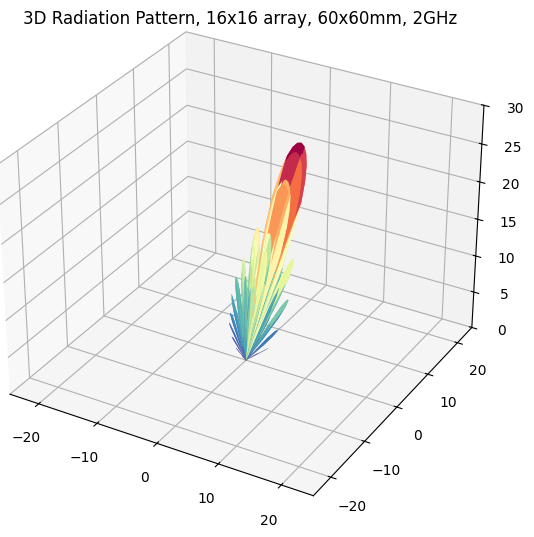

In [99]:
analyze.test_plot_ff_3d()

In [ ]:
# Standard array comparison without beamsteering
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[1, 2, 4],
    yn=1,
    dxs=[60, 90],
    figname="antenna_array_comparison",
)

In [ ]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[4],  # Only showing 4-element arrays which should have beamsteering sims
    yn=4,
    dxs=[60],
    steering_theta=0,  # 30 degree beam steering
    figname="antenna_array_beamsteering_30deg",
)

In [ ]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[4],  # Only showing 4-element arrays which should have beamsteering sims
    yn=4,
    dxs=[60],
    steering_theta=15,  # 30 degree beam steering
    figname="antenna_array_beamsteering_30deg",
)

In [ ]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[16],  # Only showing 4-element arrays which should have beamsteering sims
    yn=16,
    dxs=[60],
    steering_theta=0,  # 30 degree beam steering
    figname="antenna_array_beamsteering_00deg",
)

In [ ]:
# Array comparison with beamsteering at 30 degrees
analyze.plot_sim_and_af(
    sim_dir=Path.cwd() / "src" / "sim" / "antenna_array",
    freq=2.45e9,
    xns=[16],  # Only showing 4-element arrays which should have beamsteering sims
    yn=16,
    dxs=[60],
    steering_theta=15,  # 30 degree beam steering
    figname="antenna_array_beamsteering_15deg",
)